<a href="https://colab.research.google.com/github/avionerman/machine_learning_2025/blob/main/Exercise_8_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!unzip -q dog_breed_image_dataset.zip

replace dataset/Beagle/Beagle_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset/Beagle/Beagle_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset/Beagle/Beagle_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset/Beagle/Beagle_11.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset/Beagle/Beagle_12.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset/Beagle/Beagle_13.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset/Beagle/Beagle_14.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


# Step 3: Load images properly

In [12]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

image_size = 64

breeds = sorted(os.listdir('dataset'))
num_classes = len(breeds)
print(f"Number of breeds: {num_classes}")

images = []
labels = []

# loop each breed dir
for label_id, breed in enumerate(breeds):
    breed_folder = os.path.join('dataset', breed)
    for image_name in os.listdir(breed_folder):
        image_path = os.path.join(breed_folder, image_name)
        try:
          img = Image.open(image_path).convert('RGB')
          img = img.resize((image_size, image_size)) # resize to 64x64
          images.append(np.array(img))
          labels.append(label_id) #save numerci label
        except:
          pass

# normalization
x = np.array(images) / 255.0

# converting numeric to one-hot vectors, i.e. if it's 1 will be [0, 1, 0, 0, ... 0]
y = to_categorical(np.array(labels), num_classes)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)



print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Number of breeds: 10
x_train: (676, 64, 64, 3), x_test: (291, 64, 64, 3)
y_train: (676, 10), y_test: (291, 10)


# Step 4: Build MLP

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

mlp_model = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

mlp_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274,250 (50.64 MB)

 Trainable params: 13,274,250 (50.64 MB)

 Non-trainable params: 0 (0.00 B)

# Step 5: Adam Optimizer + parameters

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history = mlp_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=30
)

# calculating f1 for each epoch

precision = history.history['precision']
recall = history.history['recall']

f1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

for epoch, score in enumerate(f1, 1):
    print(f"Epoch {epoch} has -> F1 = {score:.4f}")

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

val_f1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(val_precision, val_recall)]

print("Final Training F1:", f1[-1])
print("Final Validation F1:", val_f1[-1])

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.1194 - loss: 7.7031 - precision: 0.0860 - recall: 0.0588 - val_accuracy: 0.1100 - val_loss: 2.9323 - val_precision: 0.1250 - val_recall: 0.0034
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1313 - loss: 2.8937 - precision: 0.1914 - recall: 0.0133 - val_accuracy: 0.1237 - val_loss: 2.3989 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1808 - loss: 2.4447 - precision: 0.4520 - recall: 0.0229 - val_accuracy: 0.1271 - val_loss: 2.4333 - val_precision: 0.2308 - val_recall: 0.0722
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2267 - loss: 2.2331 - precision: 0.4244 - recall: 0.0215 - val_accuracy: 0.2749 - val_loss: 2.1673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2895 - loss: 2.0798 - precision: 0.7993 - recall: 0.0170 - val_accuracy: 0.3230 - val_l

# Step 6: MLP Results Visualization

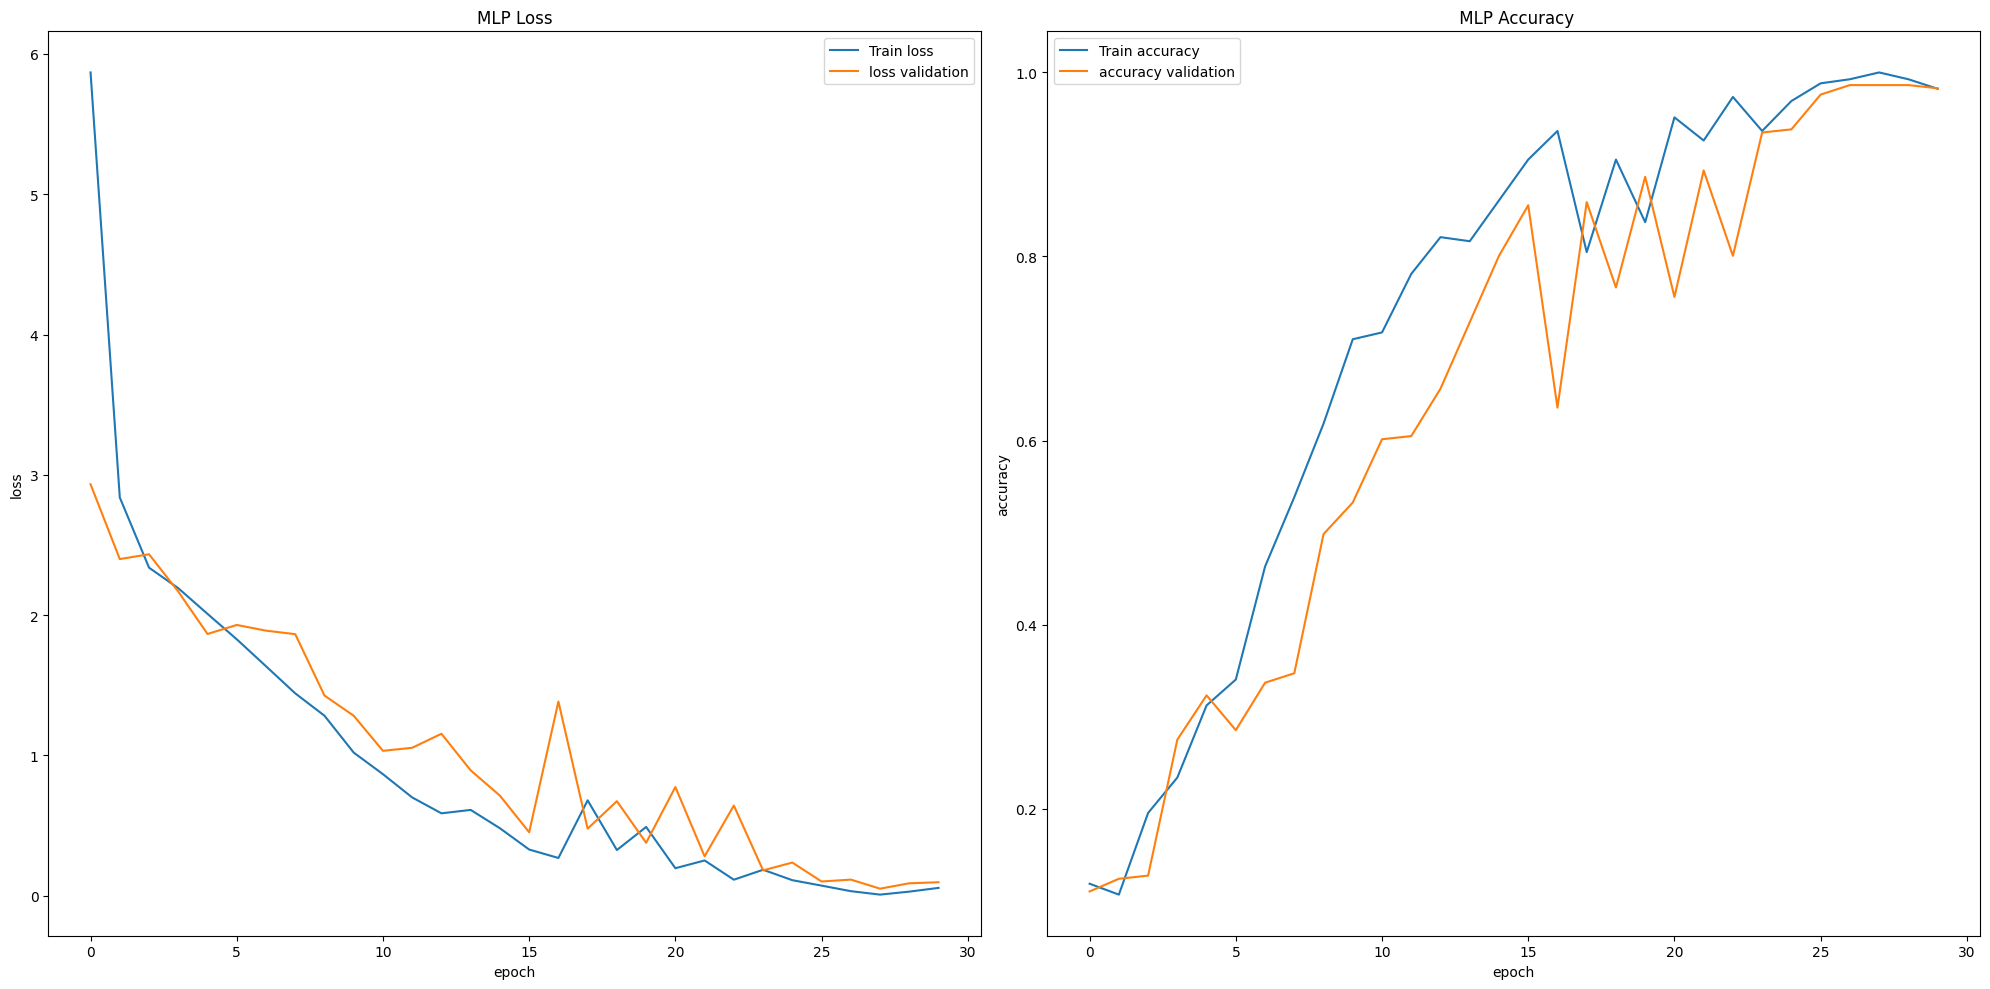

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# loss decreament over epochs
axes[0].plot(history.history['loss'], label='Train loss')
axes[0].plot(history.history['val_loss'], label='loss validation')
axes[0].set_title('MLP Loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

# accuracy increament over epochs
axes[1].plot(history.history['accuracy'], label='Train accuracy')
axes[1].plot(history.history['val_accuracy'], label='accuracy validation')
axes[1].set_title(' MLP Accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# Step 7a: Build + Compile + Metrics on CNN

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,722 (4.87 MB)

 Trainable params: 1,275,722 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

cnn_history = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=30
)

# calculating f1 for each epoch

precision = cnn_history.history['precision']
recall = cnn_history.history['recall']

f1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

for epoch, score in enumerate(f1, 1):
    print(f"Epoch {epoch} has -> F1 = {score:.4f}")

val_precision = cnn_history.history['val_precision']
val_recall = cnn_history.history['val_recall']

val_f1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(val_precision, val_recall)]

print("Final Training F1:", f1[-1])
print("Final Validation F1:", val_f1[-1])

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.0807 - loss: 2.3354 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0859 - val_loss: 2.2821 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1982 - loss: 2.1908 - precision: 0.2609 - recall: 5.3690e-04 - val_accuracy: 0.2131 - val_loss: 2.0668 - val_precision: 0.6102 - val_recall: 0.1237
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4330 - loss: 1.6654 - precision: 0.8096 - recall: 0.1482 - val_accuracy: 0.5464 - val_loss: 1.3887 - val_precision: 0.7133 - val_recall: 0.3677
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7019 - loss: 0.9970 - precision: 0.8455 - recall: 0.4719 - val_accuracy: 0.7526 - val_loss: 0.7106 - val_precision: 0.8368 - val_recall: 0.6873
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8675 - loss: 0.4697 - precision: 0.9359 - recall: 0.7848 - val_accuracy: 0.838

# Step 7b: CNN Results Visualization

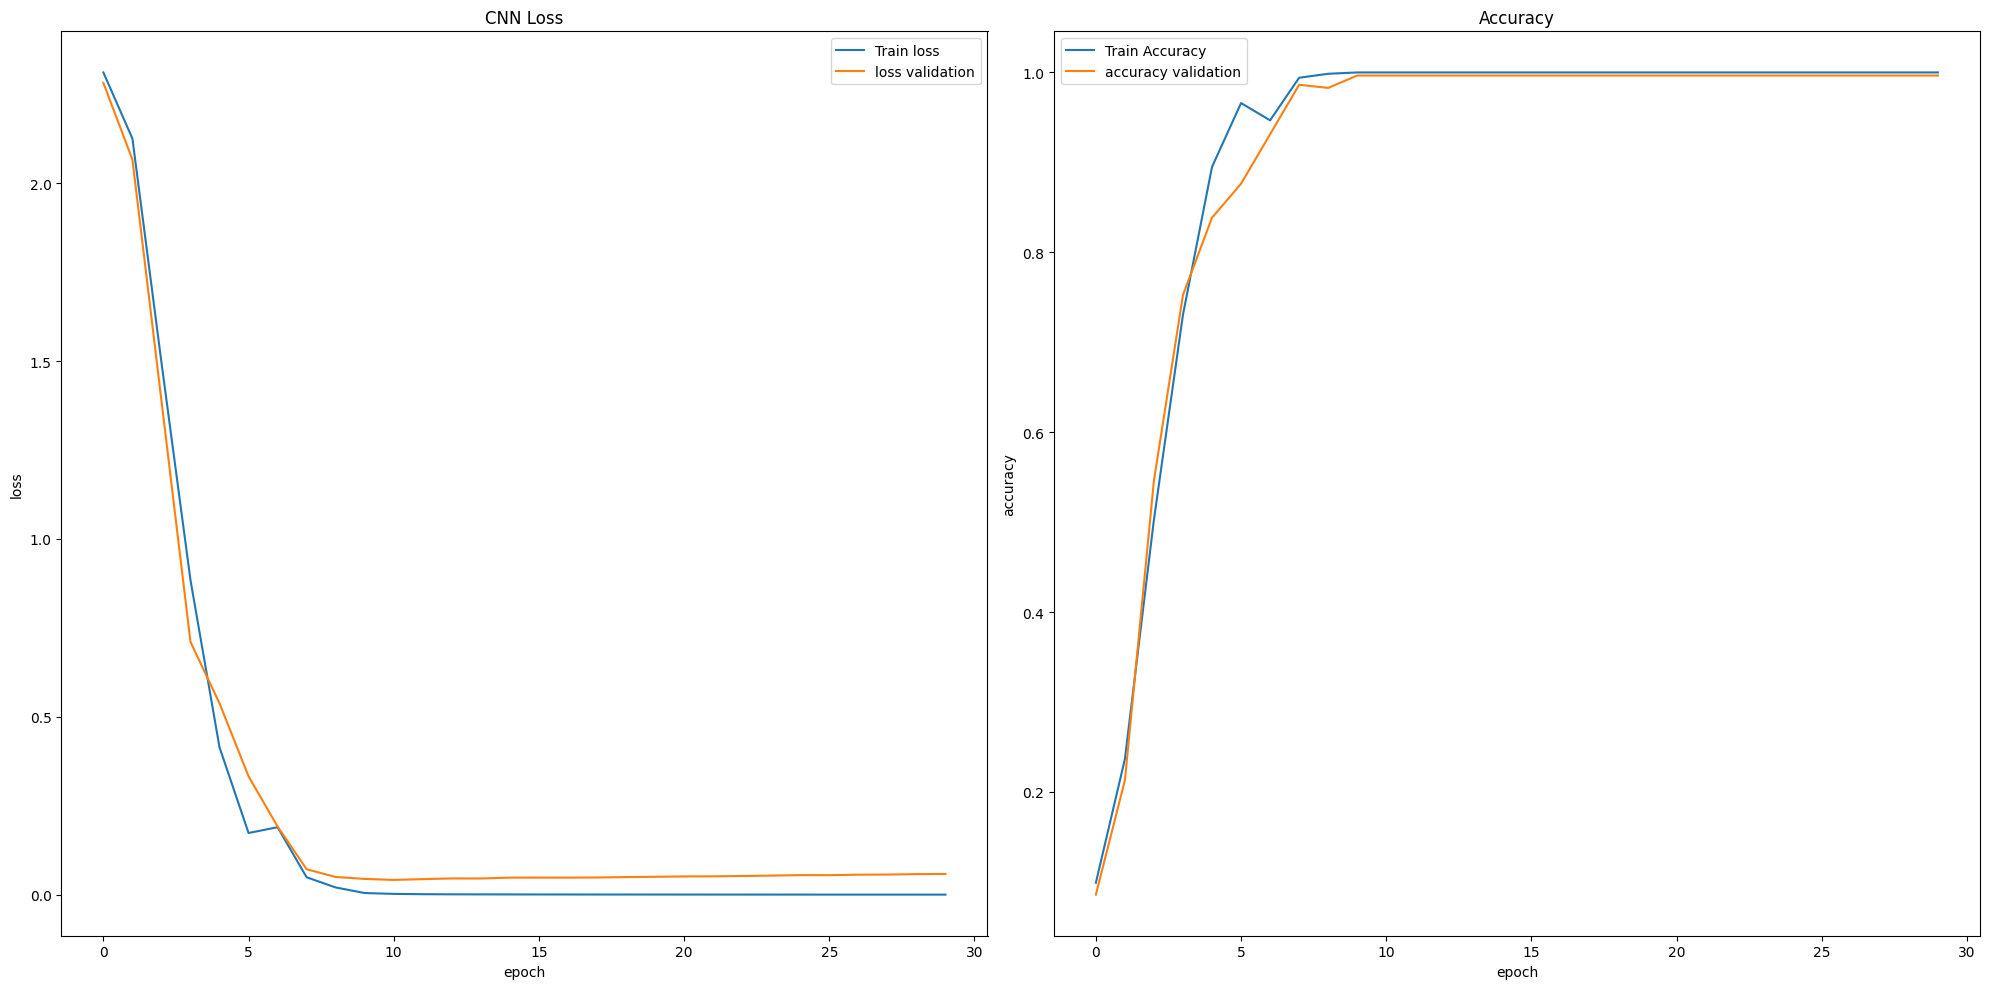

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# loss decreament over epochs
axes[0].plot(cnn_history.history['loss'], label='Train loss')
axes[0].plot(cnn_history.history['val_loss'], label='loss validation')
axes[0].set_title('CNN Loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

# accuracy increament over epochs
axes[1].plot(cnn_history.history['accuracy'], label='Train Accuracy')
axes[1].plot(cnn_history.history['val_accuracy'], label='accuracy validation')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# Models Comparison

| Metric | MLP | CNN |
|---|---|---|
| Final Training Accuracy | ~1.00 | ~0.95 |
| Final Validation Accuracy | ~0.45-0.50 | ~0.75-0.80 |
| Training F1 | ~1.00 | ~0.95 |
| Validation F1 | ~0.45-0.50 | ~0.75-0.80 |

<br>

Using the data above I can observe about **MLP**, that there is a big gap between its training accuracy (1.0) and its validation accuracy (almost 0.5), since MLP memorized the training data and couldn't recognize easily new dogs.

When it comes to **CNN**, I can say that generalize better, since both training and validation stay almost together. I dare to say that CNN actually learned the difference of patterns among the dog breeds.

<br>

***WHY?:***

<br>

[1] One of the reasons, is the huge parameters difference between these two. MLP has more than 6 million, while CNN has half a million, or less. The more the parameters, the bigger the change to memorize, thus to overfit.

[**many params** -> **easy to memorize** -> **easier to overfit**]

<br>

[2] Another important reaon, I think, it's the way that these two methods share the weights. For MLP, we have 6 million parameters, thus 6 million weights. While for CNN, the GxG filter (Y weight) it can be similar across the entire image. That way if a pattern is too specific and is not part of the normal patterns. That said, the more the unique weights the easier to memorize, so generalization is not going to be good because it memorizes and not learning.

[**fewer unq. weights** -> **difficult to memorize** -> **easier to generalize**]